# Why Violin Plots are Awesome for Feature Engineering 
## Using NLP to Identify Similar Products


___
_At Wayfair, technology and data expertise enable data scientists to transform new web datasets into intelligent machine algorithms that re-imagine how traditional commerce works.In this post, we introduce how visual tools like Violin Plots amplify our data acumen to unlock deep insights. The savvy data scientist recognizes the value of a Violin Plot when engineering new model features. We share how this method is applied in an e-commerce example where fuzzy text matching systems are developed to identify similar products sold online._
___

Key article takeaways:
  * Skillful usage of Violin Plots can improve feature engineering and selection
  * A good Violin Plot communicates more information about data irregularities than standard summary statistics and correlation coefficients

___

Good data visualizations are helpful at every step of a data science project. When starting out, the right data visualizations can inform how one should frame their data science problem. Visualizations also can help guide decisions surrounding which data inputs to use, and are helpful when evaluating model accuracy and feature importance. When debugging an existing model, visualizations help diagnose data irregularities and bias in model predictions. Finally, when communicating with business stakeholders, the right visualization makes a clear point without any additional explanation.


A type of data visualization that is particularly helpful when working on binary classification problems is the **split violin plot**. In my experience, this is a type of plot that is not nearly as famous as it should be. In brief, a split violin plot takes a variable grouped by two categories and plots a smoothed histogram of the variable in each group on opposite sides of a shared axis. The code below make a quick example plot to illustrate. 


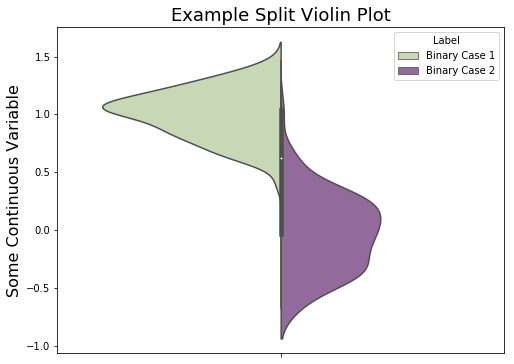

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import numpy as np

# some settings to be used throughout the notebook
pd.set_option('max_colwidth', 70)
wf_colors = ["#C7DEB1","#9763A4"]

# make some fake data for a demo split-violin plot
data1 = pd.DataFrame({'Variable': np.random.randn(100)*.2 + 1, 'Label':'Binary Case 1'})
data2 = pd.DataFrame({'Variable': np.random.randn(100)*.3, 'Label':'Binary Case 2'})
df = data1.append(data2)

# violin plots in seaborn require 2 catagorical variables ('x' and 'hue'). We use 'Label' for hue.
df['Category'] = '' # placeholder for 'x' categorical variable

# make the plot
fig, ax = plt.subplots(1,1,figsize=(8, 6))
sns.violinplot(x='Category', y="Variable", hue="Label", data=df, split=True, ax=ax, palette=wf_colors)
ax.set_xlabel(' ')
ax.set_ylabel('Some Continuous Variable', fontsize=16)
ax.set_title('Example Split Violin Plot', fontsize=18)
plt.show()

**What I like most about violin plots is that they show you the entire distribution of your data. If data inputs violate your assumptions (e.g. multimodal, full of null values, skewed by bad imputation or extreme outliers) you see the problems at a quick glance and in incredible detail.** This is better than a few representative percentiles as in a box and whisker plot, or a table of summary statistics. They avoid the problem of oversaturation prevalent in scatter plots with lots of points, and reveal outliers more clearly than you would in a histogram without a lot of fine-tuning. 

We’ll illustrate these advantages in a simple example where we use fuzzy string matching to engineer features for a binary classification problem.
___

## An Example using NLP to Identify Similar Products

At Wayfair, we develop sophisticated algorithms to parse large product catalogs and identify similar products. Part of this project involves engineering features for a model which flags two products as the same or not. Let’s start from a dataset that provides several pairs of product names and a label indicating whether or not they refer to the same item.


In [2]:
# read in data
data = pd.read_csv('productnames.csv')
df = data[['Product1', 'Product2', 'Match']]

# what does the data look like?
df.head()

,Product1,Product2,Match
0,"Da-Plex Rigid Rear Black Fixed Frame Projection Screen 60"" H x 60""...",Kohler K527E1SN DTV Prompt Shower Interface with ECO Mode,False
1,"Ruby Coronet Oval Platter 16"" Ruby Coronet",1 Door Outdoor Enclosed Bulletin Board Size: 3' H x 2' W,False
2,"Lower Case Letter Painting Print on Wrapped Canvas 28"" x 28"" - Yel...","Letter - Lower Case 'p' Stretched Wall Art Size: 28"" x 28""",True
3,"67"" x 29.5"" Soaking Bathtub Kit","Fanmats Alabama State Football Rug 20.5""x32.5""",False
4,Casino 2-Light Bath Vanity Light Satin Nickel Casino,Premium 2-in-1: Bag Toss and 3-Hole Washer Toss,False


## Fuzzywuzzy Similarity Scores

For the purpose of this fuzzy text matching illustration, we’ll use an open-source Python library called [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy) (developed by the fine folks at [SeatGeek](https://seatgeek.com)). This library contains several functions for measuring the similarity between two strings. Each function takes in two strings and returns a number between 0 and 100 representing the similarity between the strings. Functions differ in their conventions, however, and consequently the results often differ from function to function. 


In [3]:
print('Qratio: ', fuzz.QRatio('brown leather sofa', '12ft leather dark brown sofa'))
print('Wratio: ', fuzz.WRatio('brown leather sofa', '12ft leather dark brown sofa'))
print('token_sort_ratio: ', fuzz.token_set_ratio('brown leather sofa', '12ft leather dark brown sofa'))

Qratio:  57
Wratio:  86
token_sort_ratio:  100


It’s rarely obvious which function is best for a given problem. Let’s consider five different fuzzy matching methods and compute similarity scores for each pair of strings. Using these scores, we’ll create some violin plots to determine which method is best for distinguishing between matches and not matches. (You could also consider combinations of scores though this comes at a higher computational cost.)


In [4]:
def get_scores(df, func, score_name):
    """Function for getting fuzzy similarity scores using a specified function"""
    
    def _fuzzyscore(row, func=func):
        """Fuzzy matching score on two columns of pandas dataframe. Called via df.apply()

        Args:
            row (df row instance): row of pandas DataFrame with columns 'Product1' and 'Product2'
            func (function): return numeric similarity score between 'Product1' and 'Product1, defaults to 
            
        """
        return func(row['Product1'], row['Product2'])
    
    #get the actual scores
    df[score_name] = df.apply(_fuzzyscore, axis=1)


#get scores for different fuzzy functions    
get_scores(df, fuzz.QRatio, 'QRatio')
get_scores(df, fuzz.WRatio, 'WRatio')
get_scores(df, fuzz.partial_ratio, 'partial_ratio')
get_scores(df, fuzz.token_set_ratio, 'token_set_ratio')
get_scores(df, fuzz.token_sort_ratio, 'token_sort_ratio')
df.head()

,Product1,Product2,Match,QRatio,WRatio,partial_ratio,token_set_ratio,token_sort_ratio
0,"Da-Plex Rigid Rear Black Fixed Frame Projection Screen 60"" H x 60""...",Kohler K527E1SN DTV Prompt Shower Interface with ECO Mode,False,33,36,30,37,34
1,"Ruby Coronet Oval Platter 16"" Ruby Coronet",1 Door Outdoor Enclosed Bulletin Board Size: 3' H x 2' W,False,33,34,31,32,36
2,"Lower Case Letter Painting Print on Wrapped Canvas 28"" x 28"" - Yel...","Letter - Lower Case 'p' Stretched Wall Art Size: 28"" x 28""",True,45,64,50,67,59
3,"67"" x 29.5"" Soaking Bathtub Kit","Fanmats Alabama State Football Rug 20.5""x32.5""",False,24,41,27,42,43
4,Casino 2-Light Bath Vanity Light Satin Nickel Casino,Premium 2-in-1: Bag Toss and 3-Hole Washer Toss,False,38,38,35,38,37


A few lines of code is all it takes to generate split violin plots using the [Seaborn](https://seaborn.pydata.org) library. The purple distribution depicts a smoothed (sideways) histogram of fuzzy matching scores when Match is True, while the light-green shows the distribution of similarity scores when Match is False. **When two distributions have little or no overlap along the y-axis, the fuzzy matching function will do a better job distinguishing between our binary classes.**

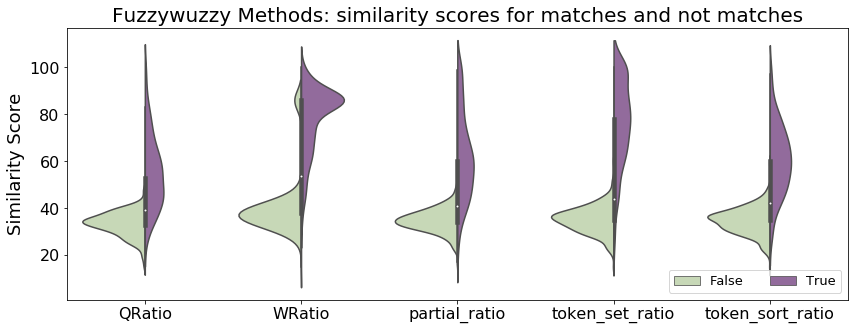

In [5]:
plot_df = pd.melt(df, id_vars=['Match'], value_vars=['QRatio','WRatio', 'partial_ratio','token_set_ratio', 'token_sort_ratio'])
plot_df.columns = ['Match', 'Function', 'Fuzzy Score']
    
fig, ax = plt.subplots(1,1, figsize=(14, 5))
sns.violinplot(x="Function", y="Fuzzy Score", hue="Match", data=plot_df, split=True, ax=ax, palette=wf_colors)
ax.set_ylabel('Similarity Score', fontsize=18)
ax.set_xlabel('')
ax.legend(loc='lower right', fontsize=13, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('Fuzzywuzzy Methods: similarity scores for matches and not matches', fontsize=20)

plt.show()
# make sure you have a "plots" folder
fig.savefig('blog_pic1.png')
    

Generally, these fuzzy matching scores do a good job in distinguishing between observations where the two names refer to the same product. For any method, a pair of names with a similarity score of 50 or more will probably refer to the same product. 


Still, we can see that some fuzzy matching functions do a better job than others in distinguishing between True and False observations. The _token-set-ratio_ plot seems to have the least overlap between the True and False distributions, followed by the plots for _token-sort-ratio_ and _WRatio_. Of our five similarity scores, the scores from these methods should perform the best in any predictive model. In comparison, notice how much more the True and False distributions overlap for the partial_ratio and QRatio methods. Scores from these methods will be less helpful as features.  

**Conclusion: Violin plots suggest that of our five similarity scores, _token-set-ratio_ would be the best feature in a predictive model, especially compared to the _partial-ratio_ or _QRatio_ methods.**

___

## Why Violin Plots are Superior to More Conventional Analyses

For comparison, let’s look at the Pearson correlation coefficients between our fuzzy-matching scores and our indicator variable for whether the pair is a match or not. 



In [6]:
df[['QRatio','WRatio', 'partial_ratio','token_set_ratio', 'token_sort_ratio', 'Match']].corr()

,QRatio,WRatio,partial_ratio,token_set_ratio,token_sort_ratio,Match
QRatio,1.000000,0.697618,0.874140,0.850323,0.920484,0.681531
WRatio,0.697618,1.000000,0.775377,0.845426,0.739139,0.803456
partial_ratio,0.874140,0.775377,1.000000,0.875790,0.816666,0.710987
token_set_ratio,0.850323,0.845426,0.875790,1.000000,0.905275,0.838103
token_sort_ratio,0.920484,0.739139,0.816666,0.905275,1.000000,0.758341
Match,0.681531,0.803456,0.710987,0.838103,0.758341,1.000000


For this data, the correlation coefficients give a similar ranking as achieved using the violin plots. The token-set-ratio method gives the strongest correlation to the Match variable while the QRatio method gives the weakest correlation. 

If our goal was only to identify the best fuzzywuzzy function to use, we apparently could have made our selection using correlation coefficients instead of violin plots. In general, however, violin plots are much more reliable and informative. Consider the following (pathological) example.

In [7]:
def make_fake_data(low, high, n=300):
    """Stacks three draws from a uniform distribution w/ bounds given by 'low' and 'high'
    
    Args:
        low (list of ints): lower bounds for the three random draws
        high (list of ints): upper bounds for the three random draws
    """
    rand_array = np.hstack((np.random.uniform(low=low[0], high=high[0], size=n),
                            np.random.uniform(low=low[1], high=high[1], size=n),
                            np.random.uniform(low=low[2], high=high[2], size=n)
                           ))
    return rand_array


# make fake data
true1 = make_fake_data([3, 33, 63], [12, 44, 72])
false1 = make_fake_data([18, 48, 78], [27, 57, 84])

true2 = make_fake_data([0, 30, 60], [15, 45, 75])
false2 = make_fake_data([15, 45, 75], [30, 60, 90])

fake_match_df = pd.DataFrame({'score1': false1, 'score2': false2, 'Match': np.full_like(false1, 0, dtype=bool)})
true_match_df = pd.DataFrame({'score1': true1, 'score2':true2, 'Match': np.full_like(true1, 1, dtype=bool)})
df = true_match_df.append(fake_match_df)

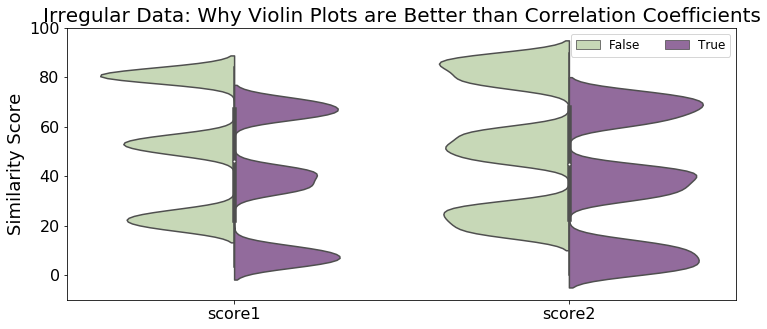

In [8]:
plot_df = pd.melt(df, id_vars=['Match'], value_vars=['score1', 'score2'])
plot_df.columns = ['Match', 'Function', 'Fuzzy Score']

fig, ax = plt.subplots(1,1, figsize=(12, 5))
sns.violinplot(x='Function', y='Fuzzy Score', hue="Match", data=plot_df, split=True, ax=ax, bw=.1,  palette=["#C7DEB1","#9763A4"])
ax.set_ylabel('Similarity Score', fontsize=18)
ax.set_xlabel('')
ax.legend(loc='upper right', fontsize=12, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('Irregular Data: Why Violin Plots are Better than Correlation Coefficients', fontsize=20)
fig.savefig('blog_pic2.png')

In these violin plots, the similarity scores on the left appear to be more helpful in separating between matches and not-matches. There is less overlap between the True and False observations and the observations are more tightly clustered into their respective groups.

However, notice that the relationship between the similarity scores and the True/False indicator is not at all linear or even monotone. As a result, correlation coefficients can fail to correctly guide our decision on which set of scores to use. Is this true? Let’s take a look.

In [9]:
df.corr()

,Match,score1,score2
Match,1.000000,-0.279448,-0.290219
score1,-0.279448,1.000000,0.980994
score2,-0.290219,0.980994,1.000000


Here, the correlation coefficients of score1 and score2 against the outcome variable are quite close. However, the plot on the right –the one that doesn’t cleanly separate True and False observations– has the stronger correlation coefficient. If we blindly took the series with the strongest correlation, we would choose the less helpful of the two features.


## Wrapping up…

To summarize:
  -	**Split violin plots** are a great way to visualize your data at a quick glance, especially when dealing with binary classification problems. 
  -	Violin plots can guide us in **feature engineering and selection** by revealing the variables that best separate the two classification outcomes. 
  -	**Correlation coefficients**, in comparison, can accomplish a similar task when the relationship between the features and labels are linear. When linearity is violated, the correlation coefficients are not helpful for feature selection.
  
There are certainly limits to this approach. Nothing that requires an “eye test” is scalable to many features. Also, violin plots have a few important parameters which, if not properly set, can hide important patterns in the data. Still, when properly used, split violin plots are a great tool for binary classification type problems.


**Acknowledgements**:
Thanks to Zhenyu Lai, Aditya Karan, Brad Fay and Laura Tengelsen for excellent editing and feedback. 

**Authors:** Benjamin Tengelsen
